In [1]:
import pandas as pd
import os
import json
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [2]:
names_real = ["soccer", "manufacturing", "intel_lab"]
names_real_exp = ["soccer_exp", "manufacturing_exp", "intel_lab_exp"]
# names_real_exp = [ "manufacturing_exp"]
# names_real_exp = ["soccer_exp"]
names_real_exp = ["intel_lab_exp"]

width = 1000
height = 600

In [3]:
data = "output/timeQueries/influx/"
results = "results.csv"

sql_folder = "influxDBResults"
tti_folder = "ttiResults"
names = names_real_exp

In [4]:
results_paths = [os.path.join(data, name, results)  for name in names]
results_paths

['output/timeQueries/influx/intel_lab_exp/results.csv']

In [7]:
dfs = [pd.read_csv(df) for df in results_paths]

In [25]:
def plot_time(df, name):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 3, 1]})
    fig.suptitle(f"Time and average time in {name} dataset")
    axs[0].plot(df["TTI Time (sec)"], label= "VS Cache")
    axs[0].plot(df["RAW TTI Time (sec)"], label="RAW Cache")
    axs[0].plot(df["InfluxDB Time (sec)"], label="Μ4")
        
    axs[1].plot(df["TTI IO Count"], label= "VS Cache")
    axs[1].plot(df["RAW TTI IO Count"], label="RAW Cache")

    axs[2].bar(0, df["TTI Time (sec)"].mean())
    axs[2].bar(1, df["RAW TTI Time (sec)"].mean())
    axs[2].bar(2, df["InfluxDB Time (sec)"].mean())
    axs[2].set_xticklabels([])
    
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache", "Μ4"])
    plt.show()


def plot_memory(df, name):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Memory and average memory in {name} dataset")
    i = 0
    axs[0].plot(df["TTI Memory (b)"], label= "VS Cache")
    axs[0].plot(df["RAW TTI Memory (b)"], label="RAW Cache")

    axs[1].bar(0, df["TTI Memory (b)"].mean())
    axs[1].bar(1, df["RAW TTI Memory (b)"].mean())
    axs[1].set_xticklabels([])
    i+=1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache"])
    plt.show()
    
def plot_compaction(df, name):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Data Compaction in {name} dataset")
    i = 0
    
    df["TTI compaction"] = df["TTI results size"]/df["RAW TTI results size"]
    df["InfluxDB compaction"] = df["InfluxDB results size"]/df["RAW TTI results size"]

    axs[0].plot(df["TTI compaction"], label= "VS Cache")
    axs[0].plot(df["InfluxDB compaction"], label="Μ4")

    axs[1].bar(0, df["TTI compaction"].mean())
    axs[1].bar(1, df["InfluxDB compaction"].mean())
    axs[1].set_xticklabels([])
    i+= 1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache", "Μ4"])

    plt.show()
    
def plot_time_per_operation(dfs, name):
    plt.clf()
    width = 0.3
    i = 0
    k = len(dfs)
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle(f"Average time per operation in {name} dataset")
    for df in dfs:
        axs[i].title.set_text(k_list[i])
        tti = (df[["operation", "TTI Time (sec)"]].groupby("operation").aggregate('mean'))
        raw = (df[["operation", "RAW TTI Time (sec)"]].groupby("operation").aggregate('mean'))
        psql = (df[["operation", "InfluxDB Time (sec)"]].groupby("operation").aggregate('mean'))
        r = np.arange(3)
        axs.bar(r, tti['TTI Time (sec)'], width=width, label="VS Cache")
        axs.bar(r + width, raw['RAW TTI Time (sec)'],  width=width, label= "RAW Cache")
        axs.bar(r + 2*width, psql['InfluxDB Time (sec)'], width=width,  label = "Μ4")
        axs.set_xticks(r + width, ['PAN', 'ZI', 'ZO'])
        i+= 1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache", "Μ4"])

    plt.show()

<Figure size 640x480 with 0 Axes>

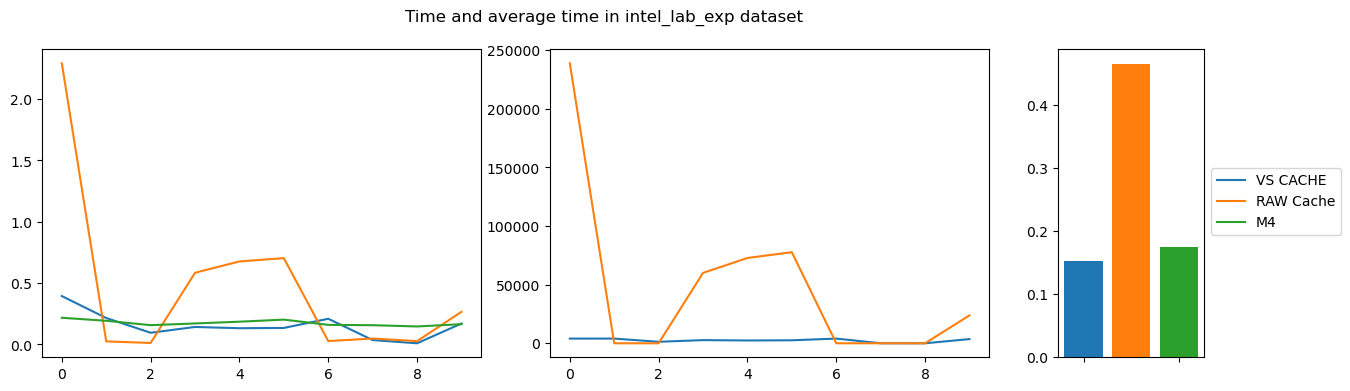

In [26]:
j = 0
for i in range(0, len(dfs)):
    plot_time(dfs[i], names[i])

<Figure size 640x480 with 0 Axes>

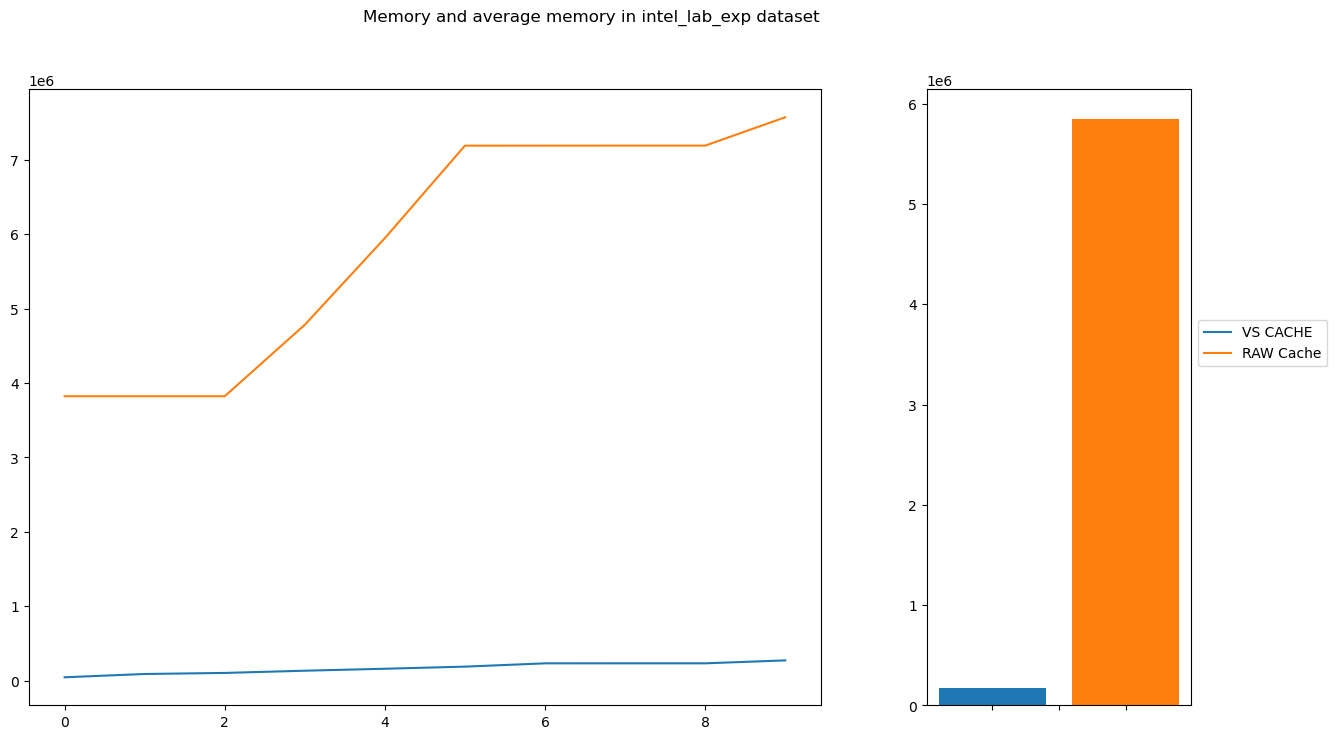

In [27]:
j = 0
for i in range(0, len(dfs)):
    plot_memory(dfs[i], names[i])

<Figure size 640x480 with 0 Axes>

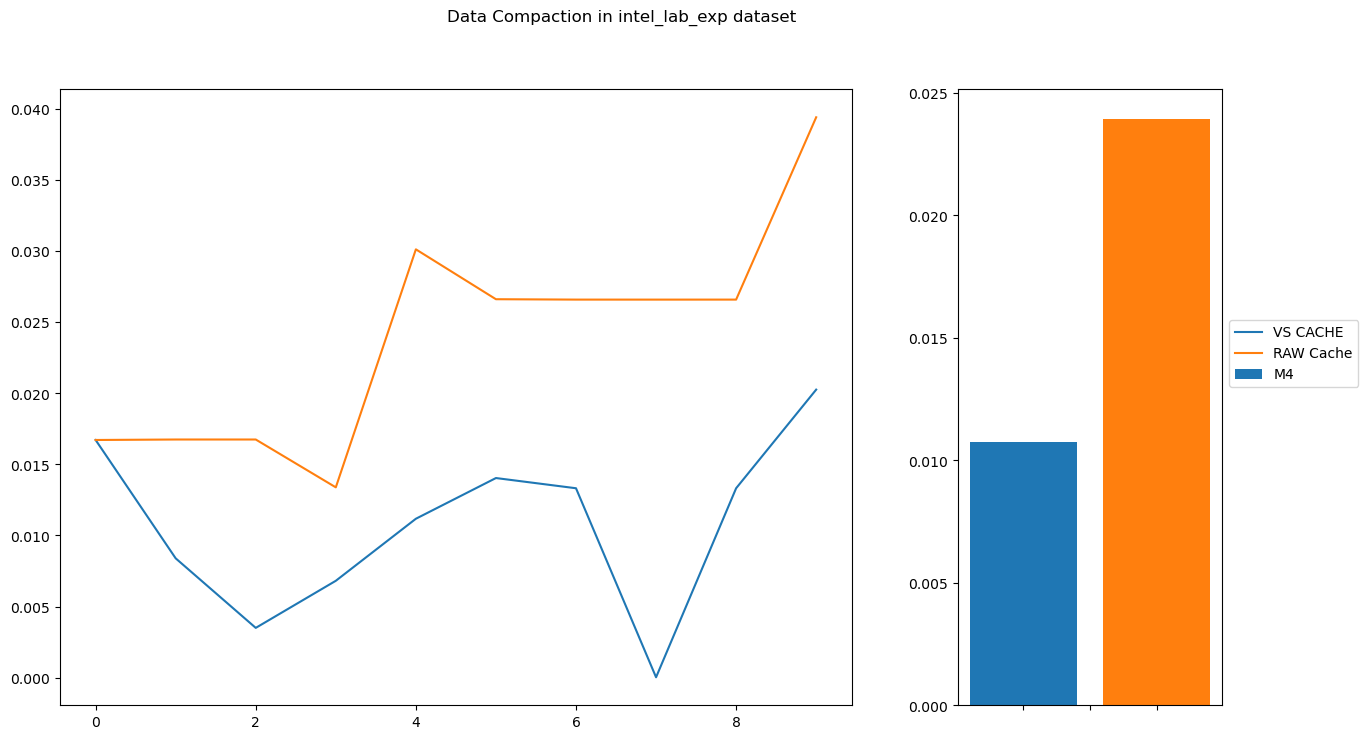

In [28]:
j = 0
for i in range(0, len(dfs)):
    plot_compaction(dfs[i], names[i])

In [29]:
# j = 0
# for i in range(0, len(dfs), len(k_list)):
#     plot_time_per_operation(dfs[i : i + len(k_list)], names[j])
#     i += 1

In [14]:
from skimage import io, color
from skimage.metrics import structural_similarity as compare_ssim

def plot(df, measure, name):
    dpi = 100
    plot_width, plot_height = width / dpi, height / dpi  # Convert from pixels to inches
    fig, ax = plt.subplots(figsize=(plot_width, plot_height))
    try:
        ax.set_xlim(df['timestamp'].min(), df['timestamp'].max())
        ax.set_ylim(df[measure].min(), df[measure].max())
    except:
        pass
    ax.axis('off')
    ax.set_position([0, 0, 1, 1])
    ax.plot(df['timestamp'], df[measure], color='black', antialiased=False)
    plt.savefig(name, transparent="True", pad_inches=0)
    plt.close()
    
    
def calculate_ssim(image_file1, image_file2):
    # Read the two images
    image1 = io.imread(image_file1)
    image2 = io.imread(image_file2)
    # Remove the alpha channel if present
    if image1.shape[2] == 4:
        image1 = image1[:, :, :3]
    if image2.shape[2] == 4:
        image2 = image2[:, :, :3]
    
    image1_gray = color.rgb2gray(image1)
    image2_gray = color.rgb2gray(image2)
    
    (score, _) = compare_ssim(image1_gray, image2_gray, full=True)
    # print(f"SSIM between {image_file1} and {image_file2}: {ssim_index:.4f}")
    diff = image1_gray - image2_gray
    # Search for all pixels that are different 
    # Type is <class 'numpy.ndarray'>, you can optionally convert to a list
    coords = np.argwhere(diff != 0)
    coords = coords.tolist() 
    return score, len(coords)/(width*height)


def get_mean_error(s, measures):
    a = (s.split("="))
    errs = []
    for l in a:
        if ("," in l):
            errs.append(float(l.split(",")[0]))
    errs.append(float(a[-1].split(",")[0][:-1]))
    return np.mean(errs)
    
    
def plot_indexes(df, name):

    fig, axs = plt.subplots(1, 1, figsize=(10, 8))

    tti_results_path = os.path.join(data, name, tti_folder)
    sql_results_path = os.path.join(data, name, sql_folder)

    tti_query_0 = os.path.join(tti_results_path, "query_0")
    sql_query_0 = os.path.join(sql_results_path, "query_0")

    meassure_files = os.listdir(tti_query_0)
    measures = [x.replace(".csv", "") for x in meassure_files]
    queries = os.listdir(tti_results_path)
    all_ssim = [] 
    all_diffs = [] 
    errors = df['Error'].apply(get_mean_error, args=([measures]))
    queries = sorted(queries, key=lambda x: (int(x.split("query_")[1]), x))
    for q in queries:
        j = 0
        ssim = 0
        diffs = 0
        for m in meassure_files:
            path_tti = os.path.join(tti_results_path, q)
            path_sql = os.path.join(sql_results_path, q)
            df_tti = pd.read_csv(os.path.join(path_tti, m))
            df_raw = pd.read_csv(os.path.join(path_sql, m)) 
            plot(df_tti, measures[j], f"plots/{q}-{measures[j]}-tti")
            plot(df_raw, measures[j], f"plots/{q}-{measures[j]}-raw")
            score, diff = calculate_ssim(f"plots/{q}-{measures[j]}-tti.png", f"plots/{q}-{measures[j]}-raw.png")
            ssim += score
            diffs += diff
            # os.remove("tti.png")
            # os.remove("raw.png")
            j+=1  
        avg_ssim = ssim / len(measures)
        avg_diff = diffs / len(measures)
        all_ssim.append(avg_ssim)
        all_diffs.append(avg_diff)
    fig.suptitle(f"SSIM in {name} dataset.")
    axs.plot(all_ssim, label="SSIM")
    axs.plot(errors, label="MAX Error")
    axs.set_xticks([0,5,10,15,20,25,30,35,40,45,50])
    axs.plot(all_diffs, label="Difference")
    axs.legend()
    plt.show()   

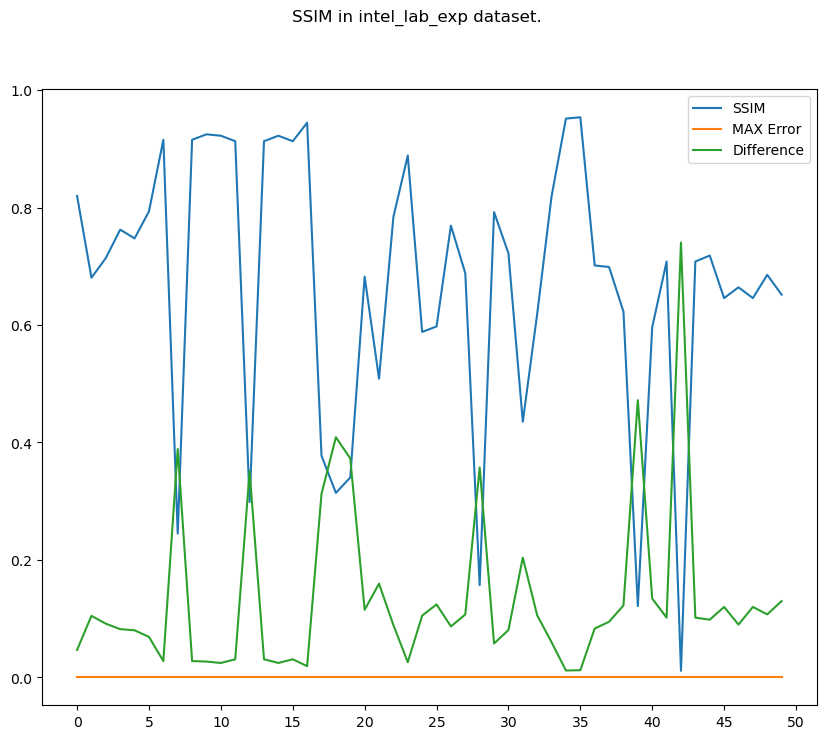

In [15]:
for i in range(0, len(dfs)):
    plot_indexes(dfs[i], names[i])